In [1]:
import pandas as pd
import scipy as sc
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Data_cleaned

In [2]:
data_cleaned = pd.read_csv("data/data_cleaned.csv")
label = data_cleaned["Categorie1"].values
features = sc.sparse.load_npz("data/feature_sparse.npz")

In [3]:
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.1, random_state=42)

### Apprentissage

In [4]:
ts = time.time()
lr = LogisticRegression()
lr.fit(X_train, y_train)
te = time.time()
print(te-ts, "sec")
train_score = lr.score(X_train,y_train) 
print(train_score) #Nombre de descriptions dont la prédiction est juste/Nombre de descriptions total

/Users/cecile/opt/anaconda3/envs/Projet4A/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


56.91470193862915 sec
0.9869777777777777


### Prediction

In [5]:
Y_train_predict = lr.predict(X_train)

In [6]:
test_score = lr.score(X_test,y_test)
print(test_score)

0.9011


### Plot

In [7]:
cat = list(set(y_train)) #recup toutes les categories

TP=[0] #chiffres bruts
FN=[0]
nb_data=[0]

for i in cat :
    cat_name = str(i)
    Y_train_predict_cat = Y_train_predict==cat_name
    y_train_cat = y_train==cat_name
    n_data = 0
    for k in y_train_cat:
        if k== True:
            n_data +=1
    nb_data += [n_data]
    A=pd.crosstab(y_train_cat, Y_train_predict_cat, rownames=["Ground True"], colnames=["Prediction"])
    TP += [A[1][1]]
    FN += [A[0][1]]

In [8]:
d = {'data':nb_data, 'True positive':TP, 'False negative':FN}
pd.DataFrame(d).T

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
data,0,5399,59,4282,1826,289,1004,331,77,2302,...,10897,1234,19173,5414,2850,180,1919,291,1647,135
True positive,0,5360,59,4232,1772,281,982,322,76,2240,...,10897,1227,19079,5405,2789,177,1904,289,1548,135
False negative,0,39,0,50,54,8,22,9,1,62,...,0,7,94,9,61,3,15,2,99,0


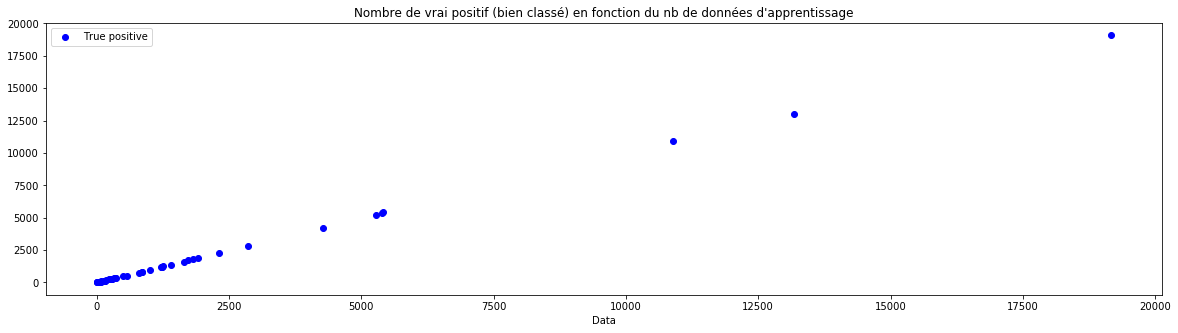

In [9]:
fig=plt.figure(figsize=(20,5))
plt.title("Nombre de vrai positif (bien classé) en fonction du nb de données d'apprentissage")
plt.plot(nb_data, TP, 'bo', label="True positive")
plt.xlabel('Data')
plt.legend()
plt.show()

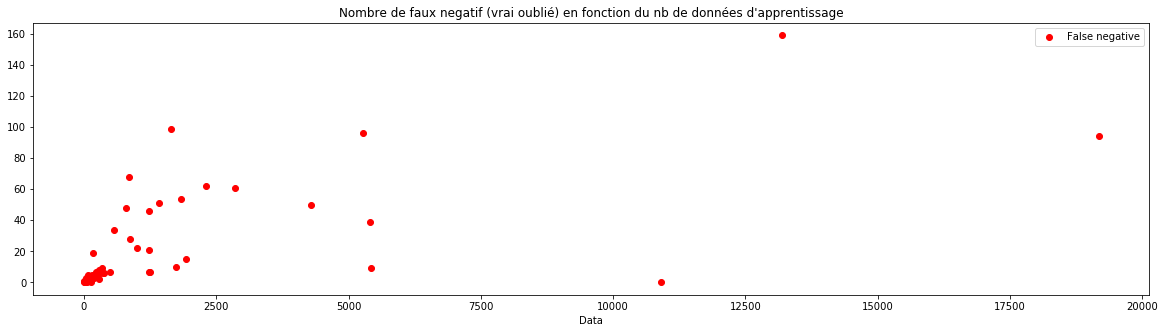

In [10]:
fig=plt.figure(figsize=(20,5))
plt.title("Nombre de faux negatif (vrai oublié) en fonction du nb de données d'apprentissage")
plt.plot(nb_data,FN, "ro", label="False negative")
plt.xlabel('Data')
plt.legend()
plt.show()

## Reduction X train

In [11]:
nb = 50000
X_small_train = X_train[0:nb]
y_small_train = y_train[0:nb]

In [12]:
lr_small = LogisticRegression()
lr_small.fit(X_small_train, y_small_train)
lr.score(X_small_train,y_small_train)

/Users/cecile/opt/anaconda3/envs/Projet4A/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.98684

In [13]:
Y_small_train_predict = lr_small.predict(X_small_train)
lr_small.score(X_test,y_test)

0.8833

In [14]:
print(train_score)
print(test_score) 

0.9869777777777777
0.9011


### Comments :

- Ok donc la prediction est moins bonne ce qui est logique car il y a moins de données d'apprentissage au préalable
- Peut etre essayer que sur les 3 plus grandes catégories voir ce que ça donne ?

# Bad_data_cleaned (cf fichier Vectorization)

In [15]:
bad_data_cleaned = pd.read_csv("data/bad_data_cleaned.csv") 
label = bad_data_cleaned["Categorie1"].values
bad_features = sc.sparse.load_npz("data/bad_feature_sparse.npz")
X_train, X_test, y_train, y_test = train_test_split(bad_features, label, test_size=0.1, random_state=42)
lr_bad = LogisticRegression()

In [16]:
ts = time.time()
lr_bad.fit(X_train, y_train)
te = time.time()
print(te-ts, "sec")

51.46840214729309 sec


/Users/cecile/opt/anaconda3/envs/Projet4A/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [17]:
Y_train_predict = lr_bad.predict(X_train)
lr_bad.score(X_train,y_train)

0.9879555555555556

In [18]:
lr_bad.score(X_test,y_test)

0.9012

### Comments :

- Ok donc on est un peu meilleur en prédiction avec "un bad_cleaning" : sans enlever les stopwords dans les tokens
- La raison ?
- Par contre on met plus de temps lors de l'apprentissage mais logique